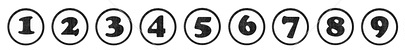
# Digit Recognizer

## Overview
This competition uses the most basic mnist data in deep learning. We need to create a model to classify the numbers in the image. <br/>
You can use other techniques instead of deep learning. However, this notebook will be written based on deep learning. <br/>
In addition, we will use "Pytorch" among the frameworks that enable deep learning.

#### My opinion :
* 1) I think it is important to use various techniques and get used to deep learning through this competition.
* 2) This book will model **Basic CNN / ResNet / DenseNet** :)

***
## My Workflow

#### 1. Import & Install libray
* Import Basic libray
* Import Enginnering libray

#### 2. Check out my data
* Check Shape / Info / Describe

#### 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Plot the null values
* Plot the label Percent
* Plot the image Data

#### 4. Feature Enginnering
* Split Train set / Validation set
* Convert to data suitable for CNN model (Dataset / Dataloader)

#### 5.Modeling
* CNN Modeling
* ResNet Modeling
* DenseNet Modeling
* Training
* Evaluating

#### 6. Submission
* Submit the predictions.
<br/><br/>
***

# 1. Import & Install libray
* Import Basic libray
* Import Enginnering libray

In [ ]:
import pandas as pd
import numpy as np
from collections import OrderedDict

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

plt.style.use('seaborn')
%matplotlib inline

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
train_df.head()

# 2. Check out my data
* Check Shape / Info / Describe

In [ ]:
print("train data shape : {}".format(train_df.shape))
print("test data shape : {}".format(test_df.shape))

In [ ]:
train_df.describe()

In [ ]:
print("Check train data values : \n{}".format(np.unique(train_df)))

In [ ]:
sns.color_palette("Greys", as_cmap=True)

In [ ]:
Greys_palette = sns.color_palette("Greys",10)
sns.palplot(Greys_palette)

# 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Plot the null values
* Plot the label Percent
* Plot the image Data

### 3-1) Plot the null values

In [ ]:
pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False), columns=["Null Count"]).head().style.background_gradient(cmap='Greys')

In [ ]:
msno.matrix(df=train_df.iloc[:,:],figsize=(20,5),color=Greys_palette[8])

### 3-2) Plot the label Percent

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
sns.countplot(x='label', data=train_df, palette=Greys_palette[::-1], ax=ax)
ax.patch.set_alpha(0)

fig.text(0.1,0.92,"distribution by Label in Mnist dataset", fontweight="bold", fontfamily='serif', fontsize=17)

### 3-3) * Plot the image Data

In [ ]:
x = train_df.iloc[:,1:].values
y = train_df.iloc[:,0].values

In [ ]:
print("X shape : {}".format(x.shape))
print("Y shape : {}".format(y.shape))

In [ ]:
fig , axes = plt.subplots(5, 5, figsize=(15,15))

x_idx = 0
y_idx = 0

for i in range(5*5):
    if x_idx == 5:
        x_idx = 0
        y_idx += 1
        
    axes[y_idx][x_idx].imshow(x[i].reshape(28,28), 'gray')
    axes[y_idx][x_idx].axis("off")
    axes[y_idx][x_idx].set_title("Target : " + str(y[i]))
    x_idx += 1

plt.show()

# 4. Feature Enginnering
* Split Train set / Validation set
* Convert to data suitable for CNN model (Dataset / Dataloader)

### 4-1) Split Train set / Validation set

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15)

In [ ]:
print("x_train shape : {}".format(x_train.shape))
print("y_train shape : {}".format(y_train.shape))
print("x_val shape : {}".format(x_val.shape))
print("y_val shape : {}".format(y_val.shape))

### 4-2) Convert to data suitable for CNN model (Dataset / Dataloader)

In [ ]:
class BasicDataset(torch.utils.data.Dataset):
    def __init__(self,x_data, y_data, is_labeled=False):
        self.x = self.get_float_type(x_data)
        self.is_labeled = is_labeled
        
        if self.is_labeled:
            self.y = self.get_long_type(y_data)
        else:
            self.y = None
        
        
    def __len__(self):
        return len(self.x)
    
    
    def __getitem__(self, index):
        global data
        data = {}
        
        x_row = self.x[index]
        data['data'] = x_row
    
        if self.is_labeled == True: 
            y_row = self.y[index]
            data['target'] = y_row
        return data
    
        
    def get_float_type(self, data):
        data = data.astype('float32')
        data /= 255
        data = data.reshape(-1, 1, 28, 28)
        return data
    
    
    def get_long_type(self, target):
        target = target.astype(torch.LongTensor)
        return target

In [ ]:
train_dataset = BasicDataset(x_train, y_train, is_labeled=True)
val_dataset = BasicDataset(x_val, y_val, is_labeled=True)

In [ ]:
print("Data of train dataset : {}\n\n\n\n".format(train_dataset[0]['data']))
print("Target of train dataset : {}".format(train_dataset[0]['target']))

In [ ]:
BATCH_SIZE = 256

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = False)

In [ ]:
dataloaders_dict = {"train": train_loader, "val": val_loader}

# 5.Modeling
* CNN Modeling
* ResNet Modeling
* DenseNet Modeling
* Training
* Evaluating

### 5-1) CNN Modeling

In [ ]:
INPUT_DIM = 1
HIDDEN_DIM_1 = 32
HIDDEN_DIM_2 = 64
OUTPUT = 10

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output):
        super(BasicCNN, self).__init__()
        
        self.convolution_layer = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(input_dim, hidden_dim_1, 3, 1, 0)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(2,2)),
            ('conv2', nn.Conv2d(hidden_dim_1, hidden_dim_2, 3, 1, 0)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(2,2))    
        ]))
        self.fc_layer = nn.Sequential(OrderedDict([
            ('Dense1', nn.Linear(1600, output)),
            ('softmax', nn.Softmax())
        ]))
    
    def forward(self,x):
        out = self.convolution_layer(x)
        out = out.view(out.size(0),-1)
        out = self.fc_layer(out)
        return out

In [ ]:
cnn_model = BasicCNN(INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, OUTPUT)
print(cnn_model)

### 5-2) ResNet Modeling

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, data_dim, layer_name, is_last_layer=False):
        super(ResidualBlock, self).__init__()
        self.is_last_layer = is_last_layer
        
        self.resblock_1 = nn.Sequential(OrderedDict([
            ('{}_conv1'.format(layer_name), nn.Conv2d(data_dim, data_dim, kernel_size=3, stride=1, padding=1, bias=False)),
            ('{}_batchnorm1'.format(layer_name), nn.BatchNorm2d(data_dim)),
            ('{}_relu1'.format(layer_name), nn.ReLU()),
            
            ('{}_conv2'.format(layer_name), nn.Conv2d(data_dim, data_dim, kernel_size=3, stride=1, padding=1, bias=False)),
            ('{}_batchnorm2'.format(layer_name), nn.BatchNorm2d(data_dim)),
            ('{}_relu2'.format(layer_name), nn.ReLU())
        ]))
        self.resblock_2 = nn.Sequential(OrderedDict([
            ('{}_conv1'.format(layer_name), nn.Conv2d(data_dim, data_dim, kernel_size=3, stride=1, padding=1, bias=False)),
            ('{}_batchnorm1'.format(layer_name), nn.BatchNorm2d(data_dim)),
            ('{}_relu1'.format(layer_name), nn.ReLU()),
            
            ('{}_conv2'.format(layer_name), nn.Conv2d(data_dim, data_dim, kernel_size=3, stride=1, padding=0, bias=False)),
            ('{}_batchnorm2'.format(layer_name), nn.BatchNorm2d(data_dim)),
            ('{}_relu2'.format(layer_name), nn.ReLU())
        ]))
        
        # Adjustment layer because height and width values are different
        self.set_shortcut = nn.Conv2d(data_dim, data_dim, kernel_size=3, stride=1, padding=0, bias=False)
        
        
    def forward(self, x):
        shortcut = x
        out = self.resblock_1(x)
        out = out + shortcut
        
        shortcut = self.set_shortcut(out)
        out = self.resblock_2(out)
        out = out + shortcut

        return out

In [ ]:
class ResNet_mini(nn.Module):
    def __init__(self, input_dim, output):
        super(ResNet_mini, self).__init__()
        self.FirstBlock = nn.Sequential(OrderedDict([
            ('FirstBlock_conv1', nn.Conv2d(input_dim, 64, kernel_size=4, stride=2, padding=4, bias=False)),
            ('FirstBlock_batchnorm1', nn.BatchNorm2d(64)),
            ('FirstBlock_relu1', nn.ReLU()),
            ('FirstBlock_maxpool2d1', nn.MaxPool2d(kernel_size=2, stride=2, padding=1)),
        ]))
        self.SecondBlock = ResidualBlock(64,'SecondBlock')
        self.ChangeChannel_1 = nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0)
        
        self.ThridBlock = ResidualBlock(128,'ThridBlock')
        self.ChangeChannel_2 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
        
        self.FourthBlock = ResidualBlock(256,'FourthBlock')  
        
        self.AveragePool2d = nn.AdaptiveAvgPool2d((1,1))
        
        self.FC = nn.Sequential(OrderedDict([
            ('FC_linear', nn.Linear(256, output)),
            ('FC_softmax', nn.Softmax(dim=1))
        ]))
    
    def forward(self, x):
        out = self.FirstBlock(x)

        out = self.SecondBlock(out)
        out = self.ChangeChannel_1(out)

        out = self.ThridBlock(out)
        out = self.ChangeChannel_2(out)

        out = self.FourthBlock(out)

        out = self.AveragePool2d(out)
        out = out.view(out.size(0), -1)
        out = self.FC(out)
        
        return out

In [ ]:
resnet_model = ResNet_mini(INPUT_DIM, OUTPUT)
print(resnet_model)

### 5-3) DenseNet Modeling

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self,input_dim, layer_name):
        super(DenseBlock, self).__init__()
        
        hidden_dim = input_dim * 2
        
        self.denseblock1 = nn.Sequential(OrderedDict([
            ('{}_batchnorm1'.format(layer_name), nn.BatchNorm2d(input_dim)),
            ('{}_relu1'.format(layer_name), nn.ReLU()),
            ('{}_conv1'.format(layer_name), nn.Conv2d(input_dim, hidden_dim, kernel_size=3, stride=1, padding=1, bias=False)),
        ]))
        
        self.denseblock2 = nn.Sequential(OrderedDict([
            ('{}_batchnorm2'.format(layer_name), nn.BatchNorm2d(hidden_dim)),
            ('{}_relu2'.format(layer_name), nn.ReLU()),
            ('{}_conv2'.format(layer_name), nn.Conv2d(hidden_dim, 32, kernel_size=3, stride=1, padding=1, bias=False)),
        ]))
        
    def forward(self, x):
        shortcut = x
        out = self.denseblock1(x)
        out = self.denseblock2(out)
        out = torch.cat([out, shortcut], 1)
        return out

In [ ]:
class DenseNet_mini(nn.Module):
    def __init__(self, input_dim, output):
        super(DenseNet_mini, self).__init__()
        self.FirstBlock = nn.Sequential(OrderedDict([
            ('FirstBlock_conv1', nn.Conv2d(input_dim, 32, kernel_size=4, stride=2, padding=4, bias=False)),
            ('FirstBlock_batchnorm1', nn.BatchNorm2d(32)),
            ('FirstBlock_relu1', nn.ReLU()),
            ('FirstBlock_maxpool2d1', nn.MaxPool2d(kernel_size=2, stride=2, padding=1)),
        ]))
        self.SecondBlock = DenseBlock(32,'SecondBlock')
        self.ThridBlock = DenseBlock(32+32,'ThridBlock')
        self.FourthBlock = DenseBlock(64+32,'FourthBlock')
        self.FifthBlock = DenseBlock(96+32,'FifthBlock')
        
        self.AveragePool2d = nn.AdaptiveAvgPool2d((1,1))
        
        self.FC = nn.Sequential(OrderedDict([
            ('FC_linear', nn.Linear(128, output)),
            ('FC_softmax', nn.Softmax(dim=1))
        ]))
    
    def forward(self, x):
        out = self.FirstBlock(x)
        out = self.SecondBlock(out)
        out = self.ThridBlock(out)
        out = self.FourthBlock(out)

        out = self.AveragePool2d(out)
        out = out.view(out.size(0), -1)
        out = self.FC(out)
        
        return out

In [ ]:
densenet_model = DenseNet_mini(INPUT_DIM, OUTPUT)
print(densenet_model)

### 5-4) Training

In [ ]:
def train_model(model, dataloaders_dict, loss_fn, optimizer, num_epochs, filename):
    model.to(device)

    history ={'train_loss' : [],
             'train_acc' : [],
              'val_loss' : [],
              'val_acc' : []
             }
    
    for epoch in range(num_epochs):
        for i, phase in enumerate(['train','val']):
            if phase=='train':
                model.train()
            else:
                model.eval()
                
            correct = 0
            epoch_loss = 0
            epoch_acc = 0 

            for data in dataloaders_dict[phase]:
                x_data = data['data'].to(device)
                y_data = data['target'].to(device)

                optimizer.zero_grad()

                predict = model(x_data)
                target = y_data
                loss = loss_fn(predict, target)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                epoch_loss += loss.item() * len(x_data)
                correct += (target==predict.argmax(axis=1)).sum()
                    
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = 100 * (correct / len(dataloaders_dict[phase].dataset))
            print("{} : [{} / {}] Loss : {:.4f}  | Accuracy : {:.2f}%".format(phase.upper(), epoch+1, num_epochs, epoch_loss, epoch_acc))
            
            history['{}_loss'.format(phase)].append(epoch_loss)
            history['{}_acc'.format(phase)].append(epoch_acc)
            
        torch.save(model.state_dict(), filename)
        print(" ")
    return history

In [ ]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('A device that proceeds with : ',device)

* CNN Model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.01)

In [ ]:
NUM_EPOCHS = 30
SAVE_MODEL_PATH = f'cnn.pth'

history = train_model(
    cnn_model,
    dataloaders_dict,
    loss_fn, 
    optimizer,
    NUM_EPOCHS,
    SAVE_MODEL_PATH
    )

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18,8))
axes[0].plot(history['train_loss'],label='train_loss')
axes[0].plot(history['val_loss'], label='val_loss')
axes[0].set_xticks(np.arange(0,NUM_EPOCHS,5))
axes[0].legend()


axes[1].plot(history['train_acc'], label='train_acc')
axes[1].plot(history['val_acc'], label='val_acc')
axes[1].set_xticks(np.arange(0,NUM_EPOCHS,5))
axes[1].legend()

plt.show()

* Mini ResNet Model

In [ ]:
# Clear cache
import gc
gc.collect()

torch.cuda.empty_cache()

In [ ]:
resnet_model = ResNet_mini(INPUT_DIM, OUTPUT)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)

In [ ]:
NUM_EPOCHS = 15
SAVE_MODEL_PATH = f'resnet.pth'

history = train_model(
    resnet_model,
    dataloaders_dict,
    loss_fn, 
    optimizer,
    NUM_EPOCHS,
    SAVE_MODEL_PATH
    )

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18,8))
axes[0].plot(history['train_loss'],label='train_loss')
axes[0].plot(history['val_loss'], label='val_loss')
axes[0].set_xticks(np.arange(0,NUM_EPOCHS))
axes[0].legend()


axes[1].plot(history['train_acc'], label='train_acc')
axes[1].plot(history['val_acc'], label='val_acc')
axes[1].set_xticks(np.arange(0,NUM_EPOCHS))
axes[1].legend()

plt.show()

* Mini DenseNet Model

In [ ]:
# Clear cache
import gc
gc.collect()

torch.cuda.empty_cache()

In [ ]:
densenet_model = DenseNet_mini(INPUT_DIM, OUTPUT)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet_model.parameters(), lr=0.0001)

In [ ]:
NUM_EPOCHS = 20
SAVE_MODEL_PATH = f'densenet.pth'

history = train_model(
    densenet_model,
    dataloaders_dict,
    loss_fn, 
    optimizer,
    NUM_EPOCHS,
    SAVE_MODEL_PATH
    )

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18,8))
axes[0].plot(history['train_loss'],label='train_loss')
axes[0].plot(history['val_loss'], label='val_loss')
axes[0].set_xticks(np.arange(0,NUM_EPOCHS,5))
axes[0].legend()


axes[1].plot(history['train_acc'], label='train_acc')
axes[1].plot(history['val_acc'], label='val_acc')
axes[1].set_xticks(np.arange(0,NUM_EPOCHS,5))
axes[1].legend()

plt.show()

### 5-5) Evaluating

In [ ]:
def evalueate_model(model, test_loader):
    predictions = []

    #model = BasicCNN()
    #model.to(device)
    #model.load_state_dict(torch.load(f'cnn.pth'))
    
    model.eval()

    for data in test_loader:
        x_data = data['data'].to(device)
        
        with torch.no_grad():
            predicts = model(x_data)
            predicts = predicts.argmax(axis=1)
            predicts = predicts.cpu().numpy()
            
            # Put the batch size data into the list one by one.
            for pred in predicts:
                predictions.append(pred)
        
    return(predictions)

In [ ]:
test_df.head()

In [ ]:
test_dataset = BasicDataset(test_df.values, y_data=None, is_labeled=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle = False)

In [ ]:
cnn_pred = evalueate_model(cnn_model, test_loader)
resnet_pred = evalueate_model(resnet_model, test_loader)
densenet_pred = evalueate_model(densenet_model, test_loader)

# 6. Submission
* Submit the predictions.

In [ ]:
cnn_submission = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
cnn_submission['Label'] = cnn_pred

resnet_submission = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
resnet_submission['Label'] = resnet_pred


densenet_submission = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
densenet_submission['Label'] = densenet_pred
cnn_submission.head()

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(20,5))

for i in range(5):
    axes[i].imshow(test_df.iloc[i].values.reshape(28,28), 'gray')
    axes[i].axis('off')
    axes[i].set_title("CNN Predict Label :" + str(cnn_pred[i]))
plt.show()

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(20,5))

for i in range(5):
    axes[i].imshow(test_df.iloc[i].values.reshape(28,28), 'gray')
    axes[i].axis('off')
    axes[i].set_title("RESNET Predict Label :" + str(resnet_pred[i]))
plt.show()

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(20,5))

for i in range(5):
    axes[i].imshow(test_df.iloc[i].values.reshape(28,28), 'gray')
    axes[i].axis('off')
    axes[i].set_title("DENSENET Predict Label :" + str(densenet_pred[i]))
plt.show()

In [ ]:
cnn_submission.to_csv('cnn_submission.csv', index=False)
resnet_submission.to_csv('resnet_submission.csv', index=False)
densenet_submission.to_csv('densenet_submission.csv', index=False)

##### reference 
* https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers

###  If this notebook is useful for your kaggling, "UPVOTE" for it 👀
#### THX to Reading My Notebook🌈